In [ ]:
# if you need any other modules feel free to add them here
import sys
sys.path.append("..") 

from my_dataset import MyDataset
from dogs import *

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
import pickle
import time
import csv
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
print('Using device: ', device)

Using device:  cuda


In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB


In [ ]:
# !unzip DogSet.zip

In [ ]:
base_folder = '../data'
sub_folder = 'DogSet'
dataset_name = 'dogs.csv'
data_path = os.path.join(base_folder, sub_folder, dataset_name)

In [ ]:
dogs_dataset = DogsDataset(os.path.join(sub_folder))

loading train...
loading valid...
loading test...


In [ ]:
train_dogs_features, train_dogs_targets = dogs_dataset.get_train_examples()
print(train_dogs_features.shape) # `[num_examples, height, width, n_channels]`)
print(train_dogs_targets.shape)

(7665, 64, 64, 3)
(7665,)


In [ ]:
valid_dogs_features, valid_dogs_targets = dogs_dataset.get_validation_examples()
valid_dogs_features.shape # `[num_examples, height, width, n_channels]`

(2000, 64, 64, 3)

In [ ]:
test_dogs_features, test_dogs_targets = dogs_dataset.get_test_examples()
test_dogs_features.shape # `[num_examples, height, width, n_channels

(555, 64, 64, 3)

In [ ]:
# Converting to datasets
train_dog_set = MyDataset(train_dogs_features, train_dogs_targets)
valid_dog_set = MyDataset(valid_dogs_features, valid_dogs_targets)
test_dog_set = MyDataset(test_dogs_features, test_dogs_targets)

In [ ]:
# Converting to dataloaders

train_dogs_loader = torch.utils.data.DataLoader(train_dog_set
                                                , batch_size=10
                                                , shuffle=True # I think for the test dataset I don't need shuffle=True
                                                , num_workers=2) 

valid_dogs_loader = torch.utils.data.DataLoader(valid_dog_set
                                                , batch_size=10
                                                , shuffle=True # I think for the test dataset I don't need shuffle=True
                                                , num_workers=2) 

test_dogs_loader = torch.utils.data.DataLoader(test_dog_set
                                                , batch_size=10
                                                , shuffle=True # I think for the test dataset I don't need shuffle=True
                                                , num_workers=2) 

In [ ]:
class Dog_Classifier_Conv(nn.Module):
    """
    This is the class that creates a convolutional neural network for classifying dog breeds
    from the DogSet dataset.

    Inputs:
    kernel_size: list of length 2 containing kernel sizes for the two convolutional layers
                 e.g., kernel_size = [(3,3), (3,3)]
    stride: list of length 2 containing strides for the two convolutional layers
            e.g., stride = [(1,1), (1,1)]

    """

    def __init__(self, kernel_size, stride):
        super(Dog_Classifier_Conv, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size[0], stride[0]) # First Convolutional layer - should have 3 input channels, because DogSet images are RGB
        self.pool = nn.MaxPool2d(2, 2) # Maxpooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size[1], stride[1]) # 2nd Conv. layer - should have 16 input layers, because that's
        self.pool = nn.MaxPool2d(2, 2) # Maxpooling

        # (I-K)/S + 1 => Size of channel after going through convolution with kernel size K, stride S, input is I
        # The formula is actually the same for a Maxpool when there is no padding or dilation i.e. with defaults

        size_first_conv = np.floor((64-kernel_size[0][0])/stride[0][0]+1) # Assuming square kernels & strides; images in DogSet are 64x64
        size_first_pool = np.floor((size_first_conv-2)/2+1)
        size_second_conv = np.floor((size_first_pool-kernel_size[1][0])/stride[1][0]+1)
        size_second_pool = np.floor((size_second_conv-2)/2+1)
        input_for_final_layer = 32 * size_second_pool * size_second_pool # 32 for the number of channels from last conv. layer

        self.fc3 = nn.Linear(int(input_for_final_layer), 10)


    def forward(self, inputs):
        # Note that the ordering of dimensions in the input may not be what you
        # need for the convolutional layers.  The permute() function can help.
        x = self.pool(F.relu(self.conv1(inputs.permute(0,3,1,2)))) # Conv. Layer expects input in shape [N, C, H, W], but default is [N, H, W, C]
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, self.num_flat_features(x)) # Flattens # IMPORTANT: Had to replace .view with .reshape, because otherwise it would break when moving to CUDA
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
def run_model(model,running_mode='train', train_set=None, valid_set=None, test_set=None,
    batch_size=1, learning_rate=0.01, n_epochs=1, stop_thr=1e-4, shuffle=True, device=torch.device('cuda')):
    """
    This function either trains or evaluates a model.

    training mode: the model is trained and evaluated on a validation set, if provided.
                   If no validation set is provided, the training is performed for a fixed
                   number of epochs.
                   Otherwise, the model should be evaluted on the validation set
                   at the end of each epoch and the training should be stopped based on one
                   of these two conditions (whichever happens first):
                   1. The validation loss stops improving.
                   2. The maximum number of epochs is reached.

    testing mode: the trained model is evaluated on the testing set

    Inputs:

    model: the neural network to be trained or evaluated
    running_mode: string, 'train' or 'test'
    train_set: the training dataset object generated using the class MyDataset
    valid_set: the validation dataset object generated using the class MyDataset
    test_set: the testing dataset object generated using the class MyDataset
    batch_size: number of training samples fed to the model at each training step
    learning_rate: determines the step size in moving towards a local minimum
    n_epochs: maximum number of epoch for training the model
    stop_thr: if the validation loss from one epoch to the next is less than this
              value, stop training
    shuffle: determines if the shuffle property of the DataLoader is on/off

    Outputs when running_mode == 'train':

    model: the trained model
    loss: dictionary with keys 'train' and 'valid'
          The value of each key is a list of loss values. Each loss value is the average
          of training/validation loss over one epoch.
          If the validation set is not provided just return an empty list.
    acc: dictionary with keys 'train' and 'valid'
         The value of each key is a list of accuracies (percentage of correctly classified
         samples in the dataset). Each accuracy value is the average of training/validation
         accuracies over one epoch.
         If the validation set is not provided just return an empty list.

    Outputs when running_mode == 'test':

    loss: the average loss value over the testing set.
    accuracy: percentage of correctly classified samples in the testing set.

    Summary of the operations this function should perform:
    1. Use the DataLoader class to generate training, validation, or test data loaders
    2. In the training mode:
       - define an optimizer (we use SGD in this homework)
       - call the train function (see below) for a number of epochs untill a stopping
         criterion is met
       - call the test function (see below) with the validation data loader at each epoch
         if the validation set is provided

    3. In the testing mode:
       - call the test function (see below) with the test data loader and return the results

    """

    if running_mode == 'train':

        # Variables to return
        loss = {}
        loss['train'] = []
        loss['valid'] = []

        accuracy = {}
        accuracy['train'] = []
        accuracy['valid'] = []

        train_dataloader = torch.utils.data.DataLoader(train_set
                                                        , batch_size=batch_size
                                                        , shuffle=shuffle # I think for the test dataset I don't need shuffle=True
                                                        , num_workers=2) 

        if valid_set:
            valid_dataloader = torch.utils.data.DataLoader(valid_set
                                                            , batch_size=batch_size
                                                            , shuffle=shuffle # I think for the test dataset I don't need shuffle=True
                                                            , num_workers=2) 

        # Solver necessary for training
        solver = optim.SGD(params=model.parameters() ,lr=learning_rate)

        # Training the given number of epochs
        for epoch in range(n_epochs):
            print(f"STARTING EPOCH #{epoch}")
            model, epoch_train_loss, epoch_train_acc = _train(model, train_dataloader, solver, device)

            loss['train'].append(epoch_train_loss)
            accuracy['train'].append(epoch_train_acc)

            # VALIDATION
            if valid_set:

                epoch_valid_loss, epoch_valid_acc = _test(model, valid_dataloader, device)

                loss['valid'].append(epoch_valid_loss)
                accuracy['valid'].append(epoch_valid_acc)

                # BREAK CONDITION
                if len(accuracy['valid']) > 1:
                    new_valid_loss = loss['valid'][-1]
                    old_valid_loss = loss['valid'][-2] # Taking -2, because the new_valid_loss has already been added

                    if old_valid_loss - new_valid_loss < stop_thr:
                        print("REACHED STOP CONDITION")
                        print("OLD_VALID_LOSS ", old_valid_loss)
                        print("NEW_VALID_LOSS ", new_valid_loss)
                        break 

        return model, loss, accuracy

    ###################
    #### TEST MODE ####
    ###################

    if running_mode == 'test':

        loss = {}
        accuracy = {}

        test_dataloader = torch.utils.data.DataLoader(test_set
                                                        , batch_size=batch_size
                                                        , shuffle=shuffle # I think for the test dataset I don't need shuffle=True
                                                        , num_workers=2) 

        loss, accuracy = _test(model, test_dataloader, device)

        return loss, accuracy


def _train(model,data_loader,optimizer,device=torch.device('cuda')):

    """
    This function implements ONE EPOCH of training a neural network on a given dataset.
    Example: training the Digit_Classifier on the MNIST dataset
    Use nn.CrossEntropyLoss() for the loss function


    Inputs:
    model: the neural network to be trained
    data_loader: for loading the netowrk input and targets from the training dataset
    optimizer: the optimiztion method, e.g., SGD
    device: we run everything on CPU in this homework

    Outputs:
    model: the trained model
    train_loss: average loss value on the entire training dataset
    train_accuracy: average accuracy on the entire training dataset
    """
    minibatches = len(data_loader)

    epoch_train_loss = 0.0
    correct = 0
    total = 0 
    model.to(device) 

    for batch, labels in data_loader: # Per this doc, (batch,labels) = trainloader.__getitem__(); https://pytorch.org/docs/stable/torchvision/datasets.html#cifar

        # moving batch/labels onto the gpu/cpu
        batch, labels = batch.to(device), labels.to(device)
        
        # zeroing the parameters of the model 
        # because we want to optimize them
        optimizer.zero_grad()
        
        # forward pass
        # getting the predictions from our model by passing in a mini-batch
        # the ouput will have shape (mini-batch-size, number-of-classes)
        # where each element of output is the probabliity of that example being
        # the classification correspoding to the index of the value
        output = model(batch.float()) # <---- Added .float() as a modification to avoid Runtime error per this post: https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ
        
        # Calculating loss
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(output, labels.long()) # <---- Added .long() per a CampusWire discussion in post #2505
        
        # Calculating accuracy
        predicted = torch.max(output.data, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # backward pass
        loss.backward()
        
        # optimize the parameters
        optimizer.step()
        
        # add the loss of a mini-batch to the list of epoch loss
        epoch_train_loss += loss.item()

    # TRAINING METRICS
    train_loss = epoch_train_loss/minibatches
    train_accuracy = 100 * correct / total

    return model, train_loss, train_accuracy


def _test(model, data_loader, device=torch.device('cuda')):
    """
    This function evaluates a trained neural network on a validation set
    or a testing set.
    Use nn.CrossEntropyLoss() for the loss function

    Inputs:
    model: trained neural network
    data_loader: for loading the netowrk input and targets from the validation or testing dataset
    device: we run everything on CPU in this homework

    Output:
    test_loss: average loss value on the entire validation or testing dataset
    test_accuracy: percentage of correctly classified samples in the validation or testing dataset
    """
    correct = 0
    total = 0
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()
    minibatches = len(data_loader)
    epoch_loss = 0.0
    # since we're testing the model we don't need to perform backprop
    with torch.no_grad(): # Disables gradient calculation to save memory; we're sure we won't be using Tensor.backward()
        for batch, labels in data_loader:
            
            batch, labels = batch, labels # So we don't modify original dataset?
            # moving batch/labels onto the gpu/cpu
            batch, labels = batch.to(device), labels.to(device)

            output = model(batch.float()) # <---- Added .float() to solve for RuntimeError
            # this gives us the index with the highest value outputed from the last layer
            # which coressponds to the most probable label/classification for an image

            loss = loss_function(output, labels.long())
            epoch_loss += loss.item()

            predicted = torch.max(output.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_loss = epoch_loss/minibatches
    

    return test_loss, test_accuracy



In [ ]:
# %%timeit -n1 -r1

model = Dog_Classifier_Conv(kernel_size = [(3,3), (3,3)]
                            , stride = [(1,1), (1,1)])

trained_model, loss, accuracy = run_model(model
                                          , running_mode='train'
                                          , train_set = train_dog_set
                                          , valid_set = valid_dog_set
                                          , batch_size = 20
                                          , learning_rate = 1e-4
                                          , n_epochs = 100
                                          , stop_thr = 1e-4
                                          , shuffle = True
                                          , device = device)

STARTING EPOCH #0
STARTING EPOCH #1
STARTING EPOCH #2
STARTING EPOCH #3
STARTING EPOCH #4
STARTING EPOCH #5
STARTING EPOCH #6
STARTING EPOCH #7
STARTING EPOCH #8
STARTING EPOCH #9
STARTING EPOCH #10
STARTING EPOCH #11
STARTING EPOCH #12
STARTING EPOCH #13
STARTING EPOCH #14
STARTING EPOCH #15
STARTING EPOCH #16
STARTING EPOCH #17
STARTING EPOCH #18
STARTING EPOCH #19
STARTING EPOCH #20
STARTING EPOCH #21
STARTING EPOCH #22
STARTING EPOCH #23
STARTING EPOCH #24
STARTING EPOCH #25
STARTING EPOCH #26
STARTING EPOCH #27
STARTING EPOCH #28
STARTING EPOCH #29
STARTING EPOCH #30
STARTING EPOCH #31
STARTING EPOCH #32
STARTING EPOCH #33
STARTING EPOCH #34
STARTING EPOCH #35
STARTING EPOCH #36
STARTING EPOCH #37
STARTING EPOCH #38
STARTING EPOCH #39
STARTING EPOCH #40
STARTING EPOCH #41
STARTING EPOCH #42
STARTING EPOCH #43
STARTING EPOCH #44
STARTING EPOCH #45
STARTING EPOCH #46
STARTING EPOCH #47
STARTING EPOCH #48
STARTING EPOCH #49
STARTING EPOCH #50
STARTING EPOCH #51
STARTING EPOCH #52
STA

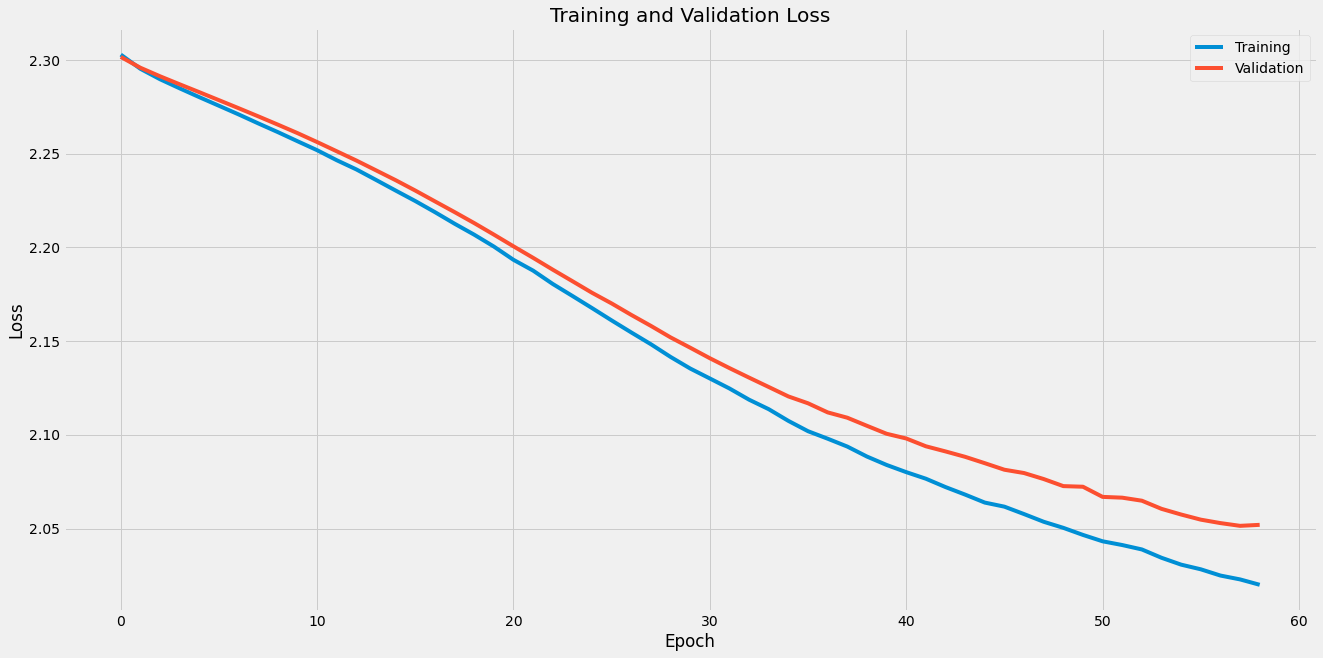

In [ ]:
plt.figure(figsize=(20,10))
n_epochs = 59
plt.plot(range(n_epochs), loss['train'], label='Training')
plt.plot(range(n_epochs), loss['valid'], label='Validation')

plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend()

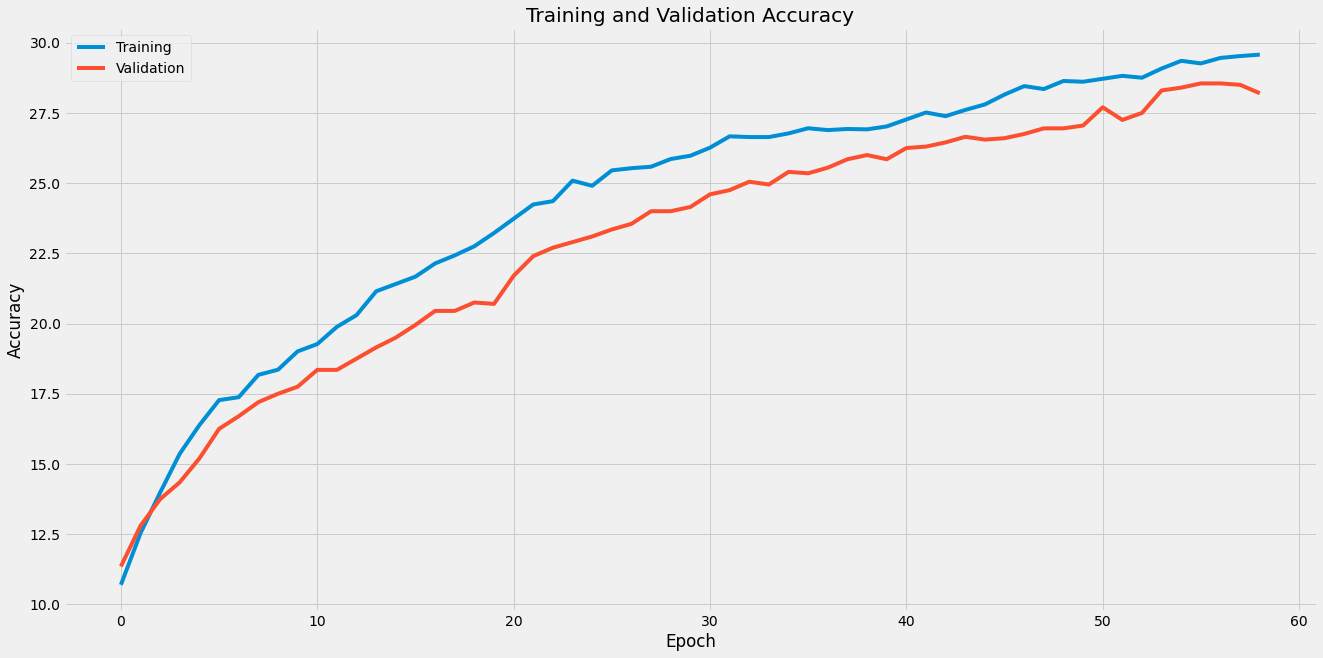

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(range(n_epochs), accuracy['train'], label='Training')
plt.plot(range(n_epochs), accuracy['valid'], label='Validation')

plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend()

In [ ]:
test_loss, test_accuracy = run_model(model
                                      , running_mode='test'
                                      , test_set = test_dog_set
                                      , batch_size = 10
                                      , shuffle = True)

In [ ]:
test_loss

2.066626780799457

In [ ]:
test_accuracy

26.306306306306308

# Synth Data

In [ ]:
def load_synth_data(dataset_name):
    """
    This function loads the synthesized data provided in a picke file
    """

    data_path = os.path.join(dataset_name)

    with open(data_path, 'rb') as handle:
        data = pickle.load(handle)

    trainX = data['trainX']
    trainY = data['trainY']

    return trainX, trainY

In [ ]:
class Synth_Classifier(nn.Module):
    """
    This is the class that creates a convolutional neural network for classifying
    synthesized images.

    Inputs:
    kernel_size: list of length 3 containing kernel sizes for the three convolutional layers
                 e.g., kernel_size = [(5,5), (3,3),(3,3)]
    stride: list of length 3 containing strides for the three convolutional layers
            e.g., stride = [(1,1), (1,1),(1,1)]

    """

    def __init__(self, kernel_size, stride):
        super(Synth_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size[0], stride[0]) 
        self.pool = nn.MaxPool2d(2, 2) # Maxpooling
        self.conv2 = nn.Conv2d(2, 4, kernel_size[1], stride[1]) # 2nd Conv. layer - should have 16 input layers, because that's
        self.pool = nn.MaxPool2d(2, 2) # Maxpooling
        self.conv3 = nn.Conv2d(4, 8, kernel_size[2], stride[2]) # 2nd Conv. layer - should have 16 input layers, because that's
        self.pool = nn.MaxPool2d(2, 2) # Maxpooling

        size_first_conv = np.floor((28-kernel_size[0][0])/stride[0][0]+1) # Assuming square kernels & strides; images in SynthData are 28x28, single channel
        size_first_pool = np.floor((size_first_conv-2)/2+1)
        size_second_conv = np.floor((size_first_pool-kernel_size[1][0])/stride[1][0]+1)
        size_second_pool = np.floor((size_second_conv-2)/2+1)
        size_third_conv = np.floor((size_second_pool-kernel_size[2][0])/stride[2][0]+1)
        size_third_pool = np.floor((size_third_conv-2)/2+1)

        input_for_final_layer = 8 * size_third_pool * size_third_pool # 8 for the number of channels from last conv. layer
        self.fc4 = nn.Linear(int(input_for_final_layer), 2)

    def forward(self, inputs):
        # Note that the ordering of dimensions in the input may not be what you
        # need for the convolutional layers.  The permute() function can help.
        x = inputs.unsqueeze(1) # Adding a single dummy dimension to represent the 1 channel
        x = self.pool(F.relu(self.conv1(x))) # No need for .permute here, so comment to the right is irrelevant --> # Conv. Layer expects input in shape [N, C, H, W], but default is [N, H, W, C]
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x)) # Flattens
        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



In [ ]:
X, y = load_synth_data("synth_data")

In [ ]:
X[0].shape

(28, 28)

In [ ]:
train_synth_set = MyDataset(X, y)

In [ ]:
model = Synth_Classifier(kernel_size = [(5,5), (3,3), (3,3)]
                            , stride = [(1,1), (1,1), (1,1)])

trained_model, loss, accuracy = run_model(model
                                          , running_mode='train'
                                          , train_set = train_synth_set
                                          , batch_size = 50
                                          , learning_rate = 1e-4
                                          , n_epochs = 50
                                          , shuffle = True
                                          , device = device)

STARTING EPOCH #0
STARTING EPOCH #1
STARTING EPOCH #2
STARTING EPOCH #3
STARTING EPOCH #4
STARTING EPOCH #5
STARTING EPOCH #6
STARTING EPOCH #7
STARTING EPOCH #8
STARTING EPOCH #9
STARTING EPOCH #10
STARTING EPOCH #11
STARTING EPOCH #12
STARTING EPOCH #13
STARTING EPOCH #14
STARTING EPOCH #15
STARTING EPOCH #16
STARTING EPOCH #17
STARTING EPOCH #18
STARTING EPOCH #19
STARTING EPOCH #20
STARTING EPOCH #21
STARTING EPOCH #22
STARTING EPOCH #23
STARTING EPOCH #24
STARTING EPOCH #25
STARTING EPOCH #26
STARTING EPOCH #27
STARTING EPOCH #28
STARTING EPOCH #29
STARTING EPOCH #30
STARTING EPOCH #31
STARTING EPOCH #32
STARTING EPOCH #33
STARTING EPOCH #34
STARTING EPOCH #35
STARTING EPOCH #36
STARTING EPOCH #37
STARTING EPOCH #38
STARTING EPOCH #39
STARTING EPOCH #40
STARTING EPOCH #41
STARTING EPOCH #42
STARTING EPOCH #43
STARTING EPOCH #44
STARTING EPOCH #45
STARTING EPOCH #46
STARTING EPOCH #47
STARTING EPOCH #48
STARTING EPOCH #49


In [ ]:
# We have TWO, 5x5 kernels
trained_model.conv1.weight

Parameter containing:
tensor([[[[ 0.0575,  0.0426,  0.0457, -0.0126,  0.0260],
          [-0.1576, -0.1033, -0.1909,  0.1288, -0.1639],
          [-0.0763,  0.0567,  0.1546, -0.1765, -0.1649],
          [-0.0063, -0.0618,  0.0364,  0.0053,  0.0206],
          [ 0.1919,  0.0772, -0.0702,  0.0178, -0.0569]]],


        [[[ 0.1996, -0.1399, -0.0903, -0.0046, -0.0782],
          [ 0.1776,  0.1558,  0.0419, -0.0778, -0.0463],
          [ 0.1394, -0.1060, -0.1861, -0.0688,  0.1493],
          [ 0.0629,  0.1076,  0.0698,  0.0815,  0.0559],
          [-0.1324,  0.1524,  0.1262,  0.1843, -0.0532]]]], device='cuda:0',
       requires_grad=True)

In [ ]:
print(trained_model.conv1.weight.shape)

torch.Size([2, 1, 5, 5])


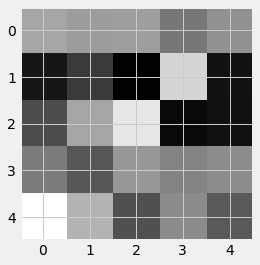

In [ ]:
plt.imshow(trained_model.conv1.weight[0][0].cpu().detach().numpy(), cmap='gray')

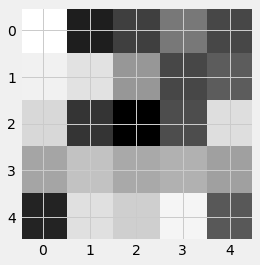

In [ ]:
plt.imshow(trained_model.conv1.weight[1][0].cpu().detach().numpy(), cmap='gray')

In [ ]:
# We have FOUR, 3x3 filters, for each of the TWO INPUT channels
trained_model.conv2.weight

Parameter containing:
tensor([[[[-0.2331,  0.1863,  0.0979],
          [ 0.0942,  0.0024, -0.1573],
          [-0.0235,  0.1051, -0.1944]],

         [[ 0.1206, -0.2284,  0.1249],
          [-0.2116,  0.1808, -0.0130],
          [ 0.2189, -0.1128, -0.1338]]],


        [[[-0.2150,  0.0452, -0.0063],
          [ 0.0681,  0.0932, -0.1613],
          [ 0.2064,  0.1731,  0.0140]],

         [[-0.1788, -0.0473,  0.0166],
          [ 0.0255, -0.1645, -0.0668],
          [ 0.2088,  0.1077, -0.0271]]],


        [[[ 0.2198, -0.0558, -0.1410],
          [-0.0046,  0.1520, -0.0277],
          [ 0.1358,  0.1363,  0.0330]],

         [[ 0.0740,  0.0338,  0.0794],
          [ 0.0874, -0.0839, -0.1510],
          [-0.0642,  0.1864,  0.1860]]],


        [[[ 0.1836, -0.0743, -0.0745],
          [ 0.1793, -0.1143, -0.1051],
          [ 0.0263, -0.0215,  0.2001]],

         [[-0.0709, -0.2077, -0.0112],
          [-0.1794, -0.1724,  0.0058],
          [-0.1392, -0.2086, -0.0988]]]], device='cuda:0', re

In [ ]:
print(trained_model.conv2.weight.shape)

torch.Size([4, 2, 3, 3])


In [ ]:
# We have EIGHT, 3x3 filters, for EACH of the FOUR input channels
trained_model.conv3.weight

Parameter containing:
tensor([[[[ 0.1148,  0.0122,  0.1599],
          [-0.0527,  0.0962, -0.0003],
          [-0.1663, -0.0989,  0.1483]],

         [[-0.1487,  0.1140,  0.1479],
          [-0.0130,  0.0496,  0.1101],
          [ 0.0705,  0.0428,  0.1543]],

         [[ 0.0111,  0.1097, -0.1280],
          [-0.0911, -0.0470,  0.0145],
          [-0.0611,  0.0744,  0.1523]],

         [[-0.1383, -0.0483,  0.0573],
          [-0.0423,  0.0005,  0.0886],
          [ 0.0058, -0.0522,  0.0583]]],


        [[[ 0.0924,  0.0626,  0.0321],
          [-0.1556, -0.1052, -0.0971],
          [ 0.1352,  0.1505, -0.1048]],

         [[ 0.1073, -0.0950,  0.1184],
          [ 0.0735, -0.0807, -0.1105],
          [ 0.1317,  0.1545,  0.0838]],

         [[-0.0638, -0.0622, -0.0872],
          [-0.0993,  0.0337, -0.1390],
          [-0.0540, -0.0146, -0.1522]],

         [[ 0.0987,  0.0734,  0.1400],
          [ 0.0157, -0.1643,  0.0816],
          [ 0.1362, -0.0067, -0.0591]]],


        [[[-0.0887,  0

In [ ]:
print(trained_model.conv3.weight.shape)

torch.Size([8, 4, 3, 3])
